<div style="display: flex; align-items: center; justify-content: space-between;">
    <div>
    <img src="https://eo-persist.eu/wp-content/uploads/2024/03/EN-Funded-by-the-EU-POS-300x63.jpg" alt="Description" width="300">
  </div>
  <div style="flex: 1; padding-right: 20px; color: darkgray; font-style: italic; font-weight: bold;">
    <p>This project has received funding from the European Union’s Horizon 2020 research and innovation programme under grant agreement No. 101086386.</p>
  </div>
</div>

<img src="https://eo-persist.eu/wp-content/uploads/2023/03/cropped-EO-PERSIST-LOGO-v1.png" alt="EOPersist banner" width="500">

---

# ALOS2 PALSAR2 (L-band) InSAR Stack Processing with Ionospheric Correction
by Pelagia Koutsantoni, PhD Candidate in Remote Sensing Laboratory at National University of Athens

---

**Aknownledgements**

This notebook was created under the framework of [EO-PERSIST](https://eo-persist.eu/about/) project funded by EU and the HORIZON TMA MSCA Staff Exchanges call. The ALOS2 PALSAR2 data used for the demostration purposes are made available through the ESA JAXA Mutual SAR Cooperation Agreement. The data was provided from FMI to NTUA (Pelagia Koutsantoni) for the research and educational purposes. The InSAR processing is implemented with [ISCE2](https://github.com/isce-framework/isce2) (Interferometric synthetic aperture radar Scientific Computing Environment 2) software, a open source software under the terms of the the Apache License, initially funded by NASA's Earth Science Technology Office (ESTO) under the Advanced Information Systems Technology (AIST) 2008 and currently funded under the NASA-ISRO SAR (NISAR) project.


---

## INTRODUCTION

This notebook provides a step-by-step guide for processing ALOS2 PALSAR2 stripmap images to generate interferograms corrected for ionospheric effects. It uses ISCE2’s alosStack processor to process all images as a stack (with one reference image in the stack) and calculates and corrects the ionospheric effects across the image stack network.

Unlike the standard .xml file approach, this notebook offers greater clarity about the specific steps involved, helping users better understand the processes taking place.

As SAR signals travel through the ionosphere, they interact with free electrons, resulting in various distortions to the radar signal. These effects include path delays, polarization rotation, and phase shifts, primarily due to the total electron content (TEC) along the signal path. The ionospheric influence can be attributed to both the background ionosphere and localized irregularities, leading to phenomena such as dispersion, group delay, phase advance, Faraday rotation, image shifts, and defocusing. Importantly, the induced phase delay is directly proportional to the TEC and inversely proportional to the radar frequency, making low-frequency systems like L-band more susceptible to these effects.

The `alosStack` processor [(Liang *et al.*, 2019)](https://ieeexplore.ieee.org/abstract/document/8353781) forms interferograms for each pair in the stack and computes the differential ionospheric phase using the Split Spectrum Method (SSM). Based on these differential measurements, it estimates the ionospheric phase contribution for each acquisition date (excluding the reference) and applies a correction to the original interferometric phases. This improves the accuracy of the InSAR time series, especially for L-band SAR data where ionospheric effects are more prominent.


The ionospheric phase delay ϕion as a function of the total electron content (TEC) along the radar signal's path is:

$$
\varphi_{\text{iono}} = - (\frac{4\pi K}{cf}) × TEC
$$

where K is a constant related to physical parameters of the medium, c is the speed of light in a vacuum, f is the radar frequency.

The Split-Spectrum Method (SSM) exploits the dispersive nature of the ionospheric phase to correct ionospheric effects in SAR interferometry. It applies a band-pass filter in the frequency domain to generate two sub-bands with slightly different center frequencies. Interferograms are then formed for each sub-band, and the ionospheric phase is estimated from their difference.

$$
\Delta \varphi_{\text{iono}} = \frac{f_2}{f_0 \left( f_2^2 - f_1^2 \right)} f_1 f_2 \Delta \varphi_1 - \frac{f_1}{f_0 \left( f_2^2 - f_1^2 \right)} f_1 f_2 \Delta \varphi_2
$$

where Δφ₁ and Δφ₂ represent the interferometric phase corresponding to sub-bands with center frequencies of f₁ and f₂, respectively. f₀ is the frequency of the full-bandwidth interferometric phase.

More details regarding the ionospheric correction methodology can be found in [here](https://github.com/isce-framework/isce2/blob/main/contrib/stack/alosStack/alosStack_tutorial.txt).

For downloading and installing ISCE2, as well detailed installation info, visit [here](https://github.com/isce-framework/isce2/tree/main)

At the beginning of the notebook, the user should modify the relevant sections marked with `CHANGE` to define all necessary variables for the processing workflow. Additionally, the list of excluded interferometric pairs for the ionospheric phase estimation should be updated based on the results obtained during processing. Advanced users may choose to adjust other input parameters as well; however, this is not recommended unless you are confident in the implications of these changes.

The notebook is organized into the following sections:
- **Data Overview:** This section provides detailed information about the datasets used in the notebook.
- **Setup:** In this section, the main directories required for the processing are defined. It ensures that the file paths for the input data, output results, and intermediate files are properly set up, so the notebook can run smoothly.
- **Auxiliary Data:** Here, the file paths for the auxiliary data must be defined, or instructions are provided for downloading the necessary files.
- **InSAR Processing:**) This section includes all steps related to InSAR processing, such as interferogram generation, ionospheric phase estimation, and correction of the interferometric phase.
- **Results Visualization:** The final section plots and analyzes key outputs such as unwrapped phase, corrected interferograms, and ionospheric estimates.

---
---

<a id="data-overview"></a> 
## DATA OVERVIEW

The dataset used in this notebook consists of ALOS-2 PALSAR-2 Stripmap acquisitions, which provide high-resolution L-band SAR imagery ideal for interferometric applications, especially in areas with dense vegetation or significant ionospheric activity. ALOS-2, operated by the Japan Aerospace Exploration Agency (JAXA), offers long-wavelength SAR data that are particularly well-suited for detecting ground deformation and performing ionospheric studies due to their deeper penetration and reduced sensitivity to temporal decorrelation compared to shorter wavelengths. In this notebook, the Stripmap data are used to demonstrate the complete InSAR processing chain, including the generation of interferograms and correction of ionospheric effects. Although the current example is based on Stripmap mode, the same workflow can be directly applied to ALOS-2 ScanSAR data.



![ALOS2 modes](https://www.eorc.jaxa.jp/ALOS-2/en/about/palsar2_swath_e.png)

Figure 1: PALSAR-2 Observation mode. Image source: [Japan Aerospace Exploration Agency (JAXA), PALSAR-2, ALOS-2 Website](https://www.eorc.jaxa.jp/ALOS-2/en/about/palsar2.htm).


---

<a id="set-up"></a>
## SET UP

In [5]:
# importing some useful modules
import os 
import glob
import subprocess

The user must define the following directories:

- `ISCE_INSTALLATION:` The path to the ISCE2 installation directory.
- `dataDir:` The directory containing the ALOS-2 data.
- `WorkDir:` The directory where the processing will take place.

**Note:**
The `dataDir` should follow this structure:
It must contain a subdirectory for each acquisition date, named using the YYMMDD format. Inside each date-named directory, include the corresponding image and LED files. If you're processing multiple frames, ensure all relevant files for each frame are stored accordingly.

In [6]:
# Directory where ISCE2 is installed
ISCE_INSTALLATION = '/home/pelagia/tools/src/isce2/'

# Specify the directory of alosStack processor
ISCE_STACK = os.path.join(ISCE_INSTALLATION, 'contrib/stack/alosStack')

# Directory where the ALOS-2 data are stored
dataDir = '/media/pelagia/Elements/InSAR_Iono_ISCE/test/data'

# Directory where all the processing with stored
WorkDir = '/media/pelagia/Elements/InSAR_Iono_ISCE/test/proc'

# Make a new directory if it doesnt exist
if not os.path.exists(WorkDir):
    os.makedirs(WorkDir)

#os.getcwd()

os.chdir(WorkDir)

---

<a id="auxiliary-data"></a>
## AUXIRIALY DATA

**The user should also define the paths to the DEM and water body files.**
If these files are not already available, ISCE2 can automatically download and convert them (e.g., SRTM DEMs) to the required format. This process requires valid NASA EarthData credentials.

Refer to the documentation [here](https://github.com/isce-framework/isce2#notes-on-digital-elevation-models) for instructions on how to enable this option.

In [ ]:
# dem file
dem = '/media/pelagia/Elements/InSAR_Iono_ISCE/stackHH/dem/demLat_N66_N68_Lon_E025_E028.dem.wgs84'

# water body file
wbd = '/media/pelagia/Elements/InSAR_Iono_ISCE/stackHH/dem/swbdLat_N66_N68_Lon_E025_E028.wbd'

---
---

<a id="insar-processing"></a> 
## InSAR PROCESSING 

**The InSAR processing workflow consists of the following steps:**
- **Step 0:** Define processing variables
- **Step 1:** Estimate SLC offsets and resample to a common grid
- **Step 2:** Form interferograms
- **Step 3:** Apply ionospheric correction
- **Step 4:** Filtering, phase unwrapping, and geocoding

---

## STEP 0: DEFINE PROCESSING VARIABLES

In this section, the user defines key processing variables such as reference date and processing options. These variables control the overall behavior of the InSAR workflow and must be set correctly before running the subsequent steps. 

In [7]:
# define the reference day for the stack (format: YYMMDD)
stack_ref_date = '200406' # CHANGE

# number of subsequent dates that will be used for the insar pairs
n = 4 # CHANGE

# polariazation of images 
pol = 'HH' # CHANGE

In [8]:
# list of dates stored in the dataDir
dates = sorted(os.path.basename(x) for x in (glob.glob(os.path.join(dataDir,'*'))))
ndates = len(dates)

insarpairs = []
for i in range(len(dates)):
    for j in range(1,n+1):
        try:
            insarpairs.append("{}-{}".format(dates[i],dates[i+j]))
        except:
            pass
print(f'Number of InSAR pairs that will be generated: {len(insarpairs)}')

Number of InSAR pairs that will be generated: 6


### STEP 1: ESTIMATE SLC OFFSETS & RESAMPLE TO A COMMON GRID

This section estimates the relative offsets between Single Look Complex (SLC) images to ensure precise coregistration. Once the offsets are calculated, all SLCs are resampled to a common spatial grid, aligned with the reference image of the stack to enable consistent processing.

#### STEP 1.1: READ DATA
Load required input datasets, including Single Look Complex (SLC) images, metadata, and auxiliary files.

In [ ]:
# Run the script with arguments
py_file = str(os.path.join(ISCE_STACK, "read_data.py"))
subprocess.run([
    "python", py_file, 
    "-idir", dataDir, 
    "-odir", 'dates',
    "-ref_date", stack_ref_date,
    "-sec_date", *dates,  
    "-pol", pol,
    "-virtual"
], stdout=subprocess.DEVNULL)

#### STEP 1.2: COMPUTE BASELINE
Calculate the geometric baseline between image acquisitions using orbit information.

In [ ]:
# Run the script with arguments
py_file = str(os.path.join(ISCE_STACK, "compute_baseline.py"))
subprocess.run([
    "python", py_file, 
    '-idir', 'dates', 
    '-odir', 'baseline', 
    '-ref_date', stack_ref_date, 
    '-sec_date', *dates,  
    '-baseline_center', 'baseline_center.txt', 
    '-baseline_grid', 
    '-baseline_grid_width' , '10', 
    '-baseline_grid_length' , '10'
], stdout=subprocess.DEVNULL) 

#### STEP 1.3: ESTIMATE SLC OFFSETS 
Compute the relative range and azimuth offsets between each secondary SLC and the reference SLC.

In [ ]:
for date in dates[1:]:
    py_file = str(os.path.join(ISCE_STACK, "estimate_slc_offset.py"))
    subprocess.run([
        "python", py_file, 
        '-idir', 'dates', 
        '-ref_date', stack_ref_date, 
        '-sec_date', date,  
        '-wbd', wbd, 
        '-dem', dem, 
        '-use_wbd_offset'
    ], stdout=subprocess.DEVNULL) 

#### STEP 1.4: ESTIMATE SWATH OFFSETS
Calculate the relative offsets between different swaths in the datase, if applicable, ensuring proper alignment across multiple swaths.

In [ ]:
py_file = str(os.path.join(ISCE_STACK, "estimate_swath_offset.py"))
subprocess.run([
    "python", py_file, 
    '-idir', 'dates/200406', 
    '-date', stack_ref_date, 
    '-output', 'swath_offset.txt',
    '-match'
], stdout=subprocess.DEVNULL) 

#### STEP 1.5: ESTIMATE FRAME OFFSETS
If multiple frames are provided, the offsets between different frames or image blocks within the dataset are calculated.

In [ ]:
py_file = str(os.path.join(ISCE_STACK, "estimate_frame_offset.py")
subprocess.run([
    "python", py_file, 
    '-idir', 'dates/200406', 
    '-date', stack_ref_date, 
    '-output', 'frame_offset.txt',
    '-match'
], stdout=subprocess.DEVNULL)

#### STEP 1.6: RESAMPLE TO COMMON GRID
Resample all SLCs onto a common radar coordinate grid to allow for consistent stacking and interferogram formation.

In [ ]:
for date in dates:

    print("")
    print("\033[1;94mPROCESSING DATE: {}\033[0m".format(date))
    print("\033[1;94m-----------------------------\033[0m")
    
    py_file = str(os.path.join(ISCE_STACK, "resample_common_grid.py"))
    subprocess.run([
        "python", py_file, 
        '-idir', 'dates', 
        '-odir', 'dates_resampled',
        '-ref_date', stack_ref_date, 
        '-sec_date', date,
        '-nrlks1', '2', # number of looks in range
        '-nalks1', '4', # number of looks in azimuth
        '-subband'
    ], stdout=subprocess.DEVNULL) 

#### STEP 1.7: MOSAIC PARAMETERS
This section defines the parameters used for creating a mosaic from multiple SAR images or interferograms. 

In [ ]:
py_file = str(os.path.join(ISCE_STACK, "mosaic_parameter.py"))
subprocess.run([
    "python", py_file, 
    '-idir', 'dates', 
    '-ref_date', stack_ref_date, 
    '-sec_date', *dates,
    '-nrlks1', '2', 
    '-nalks1', '4'
], stdout=subprocess.DEVNULL)

subprocess.run([
    "python", py_file, 
    '-idir', 'dates_resampled', 
    '-ref_dat', stack_ref_date, 
    '-sec_date', stack_ref_date,
    '-nrlks1', '2', 
    '-nalks1', '4'
], stdout=subprocess.DEVNULL)

#### STEP 1.8: COMPUTE LATITUDE, LONGTITUDE AND HEIGHT
In this section, the geographic coordinates (latitude, longitude) and elevation (height) of each pixel in the image are computed for the stack common grid. 

In [ ]:
os.chdir(os.path.join(WorkDir, 'dates_resampled', stack_ref_date))

py_file = str(os.path.join(ISCE_STACK, "rdr2geo.py"))
subprocess.run([
    "python", py_file, 
    '-date', stack_ref_date, 
    '-dem', dem, 
    '-wbd', wbd,
    '-nrlks1', '2', 
    '-nalks1', '4'
], stdout=subprocess.DEVNULL)

os.chdir(WorkDir)

#### STEP 1.9: COMPUTE GEOMETRICAL OFFSETS
Estimate pixel-wise geometric offsets based on sensor and target geometry.

In [ ]:
for date in dates[1:]:
    os.chdir(os.path.join(WorkDir, 'dates_resampled', date))
    
    py_file = str(os.path.join(ISCE_STACK, "geo2rdr.py"))
    subprocess.run([
        "python", py_file, 
        '-date', date, 
        '-date_par_dir', f"../../dates/{date}", 
        '-lat', f"../{stack_ref_date}/insar/{stack_ref_date}_2rlks_4alks.lat",
        '-lon', f"../{stack_ref_date}/insar/{stack_ref_date}_2rlks_4alks.lon",
        '-hgt', f"../{stack_ref_date}/insar/{stack_ref_date}_2rlks_4alks.hgt",
        '-nrlks1', '2', 
        '-nalks1', '4'
    ], stdout=subprocess.DEVNULL)

    os.chdir(WorkDir)

---
---

### STEP 2: FORM INTERFEROGRAMS
In this section, the interferograms are generated by combining the reference and  secondary SAR images. This step produces the interferometric phase, which can be used to detect surface displacements, topography, and other geophysical phenomena. The interferogram is the core product of the InSAR processing chain and is essential for further analysis, such as phase unwrapping and deformation measurement.

#### STEP 2.1: PAIR UP
SAR acquisitions are paired based on number of subsequent dates that is defined at the beginning of the notebook. 

In [ ]:
py_file = str(os.path.join(ISCE_STACK, "pair_up.py"))
subprocess.run([
    "python", py_file, 
    '-idir1', "dates", 
    '-idir2', "dates_resampled", 
    '-odir', 'pairs',
    '-ref_date', stack_ref_date, 
    '-pairs', *insarpairs
], stdout=subprocess.DEVNULL)

#### STEP 2.2: FORM INTERFEROGRAMS
Interferograms are formed by computing the phase difference between selected pairs of SAR images. 

In [ ]:
for insarpair in insarpairs:

    print("")
    print("\033[1;94mPROCESSING PAIR: {}\033[0m".format(insarpair))
    print("\033[1;94m----------------------------------\033[0m")
    
    ref_date = insarpair[:6]
    sec_date = insarpair[7:]

    os.chdir(os.path.join(WorkDir, 'pairs', insarpair))

    py_file = str(os.path.join(ISCE_STACK, "form_interferogram.py"))
    subprocess.run([
        "python", py_file, 
        '-ref_date', ref_date, 
        '-sec_date', sec_date, 
        '-nrlks1', '2',
        '-nalks1', '4' 
    ], stdout=subprocess.DEVNULL)

    os.chdir(WorkDir)

#### STEP 2.3: MOSAIC INTERFEROGRAMS
Multiple interferograms are mosaicked to create a seamless, continuous interferometric map covering a larger area, if multiple frames are provided for each date.

In [ ]:
for insarpair in insarpairs:

    ref_date = insarpair[:6]
    sec_date = insarpair[7:]
    
    os.chdir(os.path.join(WorkDir, 'pairs', insarpair))

    py_file = str(os.path.join(ISCE_STACK, "mosaic_interferogram.py"))
    subprocess.run([
        "python", py_file, 
        '-ref_date_stack', stack_ref_date,
        '-ref_date', ref_date, 
        '-sec_date', sec_date, 
        '-nrlks1', '2',
        '-nalks1', '4' 
    ], stdout=subprocess.DEVNULL)

    os.chdir(WorkDir)
    

#### STEP 2.4: ESTIMATE RESIDUAL OFFSETS BETWEEN RADAR AND DEM
The residual offsets between the radar-derived phase and the Digital Elevation Model (DEM) are estimated. 

In [ ]:
os.chdir(os.path.join(WorkDir, 'dates_resampled', stack_ref_date))

py_file = str(os.path.join(ISCE_STACK, "radar_dem_offset.py"))
subprocess.run([
    "python", py_file, 
    '-track', f"{stack_ref_date}.track.xml", 
    '-dem', dem, 
    '-wbd', f"insar/{stack_ref_date}_2rlks_4alks.wbd",
    '-hgt', f"insar/{stack_ref_date}_2rlks_4alks.hgt", 
    '-amp', f"../../pairs/{insarpairs[0]}/insar/{insarpairs[0]}_2rlks_4alks.amp",
    '-output', 'affine_transform.txt',
    '-nrlks1', '2',
    '-nalks1', '4'
], stdout=subprocess.DEVNULL)

os.chdir(WorkDir)

#### STEP 2.5: RECTIFY RANGE OFFSETS
Range offsets in the interferograms are corrected to improve the alignment of the reference and secondary images in the range direction. 

In [ ]:
for date in dates[1:]:
    
    os.chdir(os.path.join(WorkDir, 'dates_resampled', date, 'insar'))

    py_file = str(os.path.join(ISCE_STACK, "rect_range_offset.py"))
    subprocess.run([
        "python", py_file, 
        '-aff', f"../../{stack_ref_date}/insar/affine_transform.txt", 
        '-input', f"{date}_2rlks_4alks_rg.off", 
        '-output', f"{date}_2rlks_4alks_rg_rect.off", 
        '-nrlks1', '2',
        '-nalks1', '4'
    ], stdout=subprocess.DEVNULL)

    os.chdir(WorkDir)

#### STEP 2.6: DIFF INTERFEROGRAMS
Phase variations due to elevation are removed by subtracting the phase contribution from the DEM.

In [ ]:
for insarpair in insarpairs:

    print("")
    print("\033[1;94mPROCESSING PAIR: {}\033[0m".format(insarpair))
    print("\033[1;94m----------------------------------\033[0m")

    ref_date = insarpair[:6]
    sec_date = insarpair[7:]

    os.chdir(os.path.join(WorkDir, 'pairs', insarpair))
    
    py_file = str(os.path.join(ISCE_STACK, "diff_interferogram.py"))
    subprocess.run([
        "python", py_file, 
        '-idir', f"../../dates_resampled", 
        '-ref_date_stack', stack_ref_date, 
        '-ref_date', ref_date, 
        '-sec_date', sec_date,
        '-nrlks1', '2',
        '-nalks1', '4'
    ], stdout=subprocess.DEVNULL)

    os.chdir(WorkDir)

#### STEP 2.7: LOOK AND COHERENCE
Multilook the interferograms and compute coherence to assess signal quality and reduce noise.

In [ ]:
# calculate  
for insarpair in insarpairs:

    print("")
    print("\033[1;94mPROCESSING PAIR: {}\033[0m".format(insarpair))
    print("\033[1;94m----------------------------------\033[0m")

    ref_date = insarpair[:6]
    sec_date = insarpair[7:]

    os.chdir(os.path.join(WorkDir, 'pairs', insarpair))

    py_file = str(os.path.join(ISCE_STACK, "look_coherence.py"))
    subprocess.run([
        "python", py_file, 
        '-ref_date', ref_date, 
        '-sec_date', sec_date,
        '-nrlks1', '2',
        '-nalks1', '4',
        '-nrlks2', '4',
        '-nalks2', '4'
    ], stdout=subprocess.DEVNULL)

    os.chdir(WorkDir)

os.chdir(os.path.join(WorkDir, 'dates_resampled', stack_ref_date))

py_file = str(os.path.join(ISCE_STACK, "look_geom.py"))
subprocess.run([
    "python", py_file, 
    '-date', stack_ref_date, 
    '-wbd', wbd,
    '-nrlks1', '2',
    '-nalks1', '4',
    '-nrlks2', '4',
    '-nalks2', '4',
], stdout=subprocess.DEVNULL)

os.chdir(WorkDir)

---
---

### STEP 3: IONOSHPERIC CORRECTION

In this section, ionospheric corrections are applied to the interferograms using the Split Spectrum Method (SSM). SSM exploits the dispersive property of ionospheric phase to correct ionospheric effects from SAR interferometry. It uses band-pass filter in the range to create two sub-bands with slightly different center frequencies and calculates the ionospheric phase component of the interferogram based on that. 

In [ ]:
# the ionospheric phase will be calculated for all InSAR pairs
ionpairs = insarpairs.copy()

#### STEP 3.1: PAIR UP FOR IONOSPHERIC PHASE ESTIMATION
Ionospheric pairs are formed the same way as the InSAR pairs.

In [ ]:
py_file = str(os.path.join(ISCE_STACK, "pair_up.py"))
subprocess.run([
    "python", py_file, 
    '-idir1', 'dates', 
    '-idir2', 'dates_resampled',
    '-odir', 'pairs_ion',
    '-ref_date', stack_ref_date,
    '-pairs', *ionpairs,
], stdout=subprocess.DEVNULL)

#### STEP 3.2: SUB-BAND INTERFEROGRAMS
Sub-band interferograms are created by calculating the phase difference between sub-band images.

In [ ]:
for ionpair in ionpairs:  # ionpair format YYMMDD-YYMMDD

    print("")
    print("\033[1;94mPROCESSING PAIR: {}\033[0m".format(ionpair))
    print("\033[1;94m----------------------------------\033[0m")
    
    ref_date = ionpair[:6] # (format: YYMMDD)
    sec_date = ionpair[7:] # (format: YYMMDD)

    os.chdir(os.path.join(WorkDir, 'pairs_ion', ionpair))
    
    py_file = str(os.path.join(ISCE_STACK, "ion_subband.py"))
    subprocess.run([
        "python", py_file, 
        '-idir', f"../../dates_resampled", 
        '-ref_date_stack', stack_ref_date, 
        '-ref_date', ref_date, 
        '-sec_date', sec_date,
        '-nrlks1', '2', 
        '-nalks1', '4'
    ], stdout=subprocess.DEVNULL)

    os.chdir(WorkDir)

#### STEP 3.3: UNWRAP SUB-BAND INTERFEROGRAMS
Sub-band interferograms are unwrapped. 

In [ ]:
for ionpair in ionpairs:

    print("")
    print("\033[1;94mPROCESSING PAIR: {}\033[0m".format(ionpair))
    print("\033[1;94m----------------------------------\033[0m")
    
    ref_date = ionpair[:6]
    sec_date = ionpair[7:]

    os.chdir(os.path.join(WorkDir, 'pairs_ion', ionpair))
    
    py_file = str(os.path.join(ISCE_STACK, "ion_unwrap.py"))
    subprocess.run([
        "python", py_file, 
        '-idir', f"../../dates_resampled", 
        '-ref_date_stack', stack_ref_date, 
        '-ref_date', ref_date, 
        '-sec_date', sec_date,
        '-wbd', wbd,
        '-nrlks1', '2',
        '-nalks1', '4',
        '-nrlks_ion', '16', 
        '-nalks_ion', '16'
    ], stdout=subprocess.DEVNULL)

    os.chdir(WorkDir)

#### STEP 3.4: FILTER IONOSPHERE
Apply spatial filtering to the estimated ionospheric phase to reduce noise and enhance quality.

In [ ]:
for ionpair in ionpairs:

    print("")
    print("\033[1;94mPROCESSING PAIR: {}\033[0m".format(ionpair))
    print("\033[1;94m----------------------------------\033[0m")
    
    ref_date = ionpair[:6] 
    sec_date = ionpair[7:] 

    os.chdir(os.path.join(WorkDir, 'pairs_ion', ionpair))
    
    py_file = str(os.path.join(ISCE_STACK, "ion_filt.py"))
    subprocess.run([
        "python", py_file, 
        '-idir', f"../../dates_resampled",
        '-idir2', '../../dates',
        '-ref_date_stack', stack_ref_date, 
        '-ref_date', ref_date, 
        '-sec_date', sec_date,
        '-nrlks1', '2', #
        '-nalks1', '4', # 
        '-nrlks2', '4', # 
        '-nalks2', '4', # 
        '-nrlks_ion', '16', #
        '-nalks_ion', '16', # 
        '-win_min', '11', 
        '-win_max', '301', 
        '-fit', 
        '-filt',
        '-fit_adaptive',
        '-filt_secondary',
        '-win_secondary', '5'
    ], stdout=subprocess.DEVNULL)

    os.chdir(WorkDir)

#### STEP 3.5: PREPARE INTERFEROGRAMS FOR CHECKING IONOSPHERE ESTIMATION RESULTS
The initial interferograms are interopolated at the same looks as ionospheric phase images to be able to compare them.  

In [ ]:
for ionpair in ionpairs:
    
    ref_date = ionpair[:6] 
    sec_date = ionpair[7:] 

    py_file = str(os.path.join(ISCE_INSTALLATION, 'applications', "looks.py"))
    subprocess.run([
        "python", py_file, 
        '-i', f"pairs/{ionpair}/insar/diff_{ionpair}_2rlks_4alks.int",
        '-o', f"pairs_ion/{ionpair}/ion/ion_cal/diff_{ionpair}_32rlks_64alks_ori.int",
        '-r', '16', 
        '-a', '16'
    ], stdout=subprocess.DEVNULL)

    os.chdir(WorkDir)

#### STEP 3.6: CHECK IONOPHERE ESTIMATION RESULTS
The ionospheric correction is applied and figures are formed and stored at the `fig_ion` drectory. 

In [ ]:
for ionpair in ionpairs: 
    
    ref_date = ionpair[:6]  
    sec_date = ionpair[7:] 

    os.chdir(os.path.join(WorkDir, 'pairs_ion', ionpair))

    py_file = str(os.path.join(ISCE_INSTALLATION, 'applications', "imageMath.py"))
    subprocess.run([
        "python", py_file, 
        "-e", 'a*exp(-1.0*J*b)',
        "--a", f'ion/ion_cal/diff_{ionpair}_32rlks_64alks_ori.int',
        "--b", "ion/ion_cal/filt_ion_32rlks_64alks.ion",
        '-s', 'BIP',
        "-t", 'cfloat',
        '-o', f"ion/ion_cal/diff_{ionpair}_32rlks_64alks.int"  
    ], stdout=subprocess.DEVNULL)

    os.chdir(WorkDir)

py_file = str(os.path.join(ISCE_STACK, "ion_check.py"))
subprocess.run([
    "python", py_file, 
    '-idir', 'pairs_ion', 
    '-odir', 'fig_ion',
    '-pairs', *ionpairs,
], stdout=subprocess.DEVNULL)

<div style="background-color: #FFF3CD; padding: 10px; border-left: 6px solid #FFA500;">
  <strong>Note:</strong> Open the folder /fig_ion and inspect the figures for ionosphere estimation anomalies. If you find some you should exclude them from the next processes by filling them to exc_pairs variable. Anomalies will likely include very noisy interferograms, dense fringes, slight phase difference between adjacent swaths in ScanSAR, or discontinues in the phase.
</div>

Example of ionospheric image to be **excluded**.

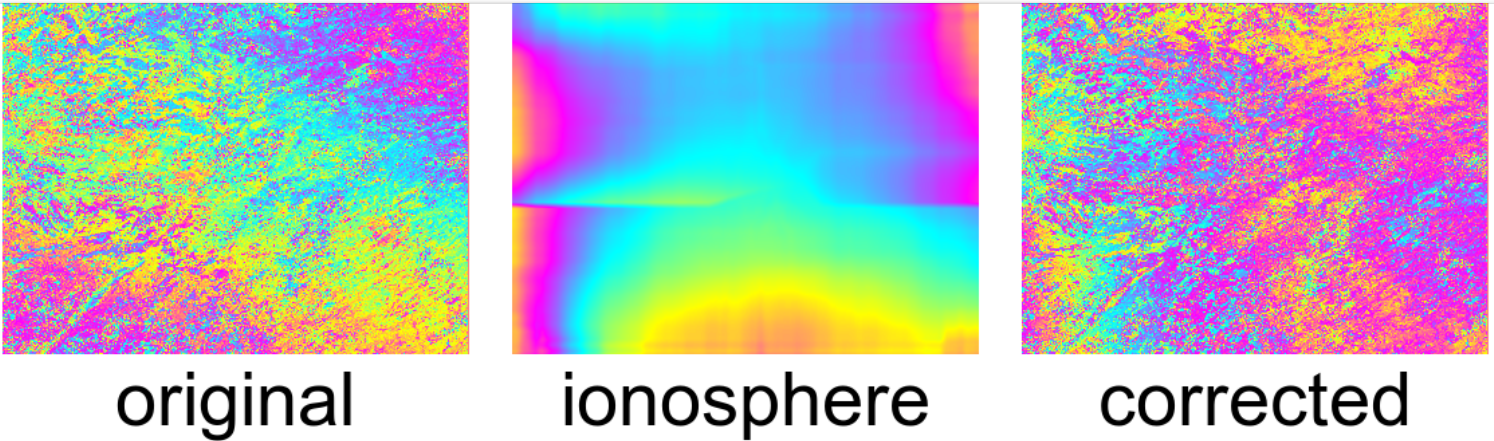

In [ ]:
# note all problematic pairs (format YYMMDD-YYMMDD) that need to be excluded in the list
# e.g. exc_pairs = ["200406-200422", "200503-200517"]
exc_pairs = [] #CHANGE

In [ ]:
#plot the baselines to ensure that the network is connected after excluding some ion pairs
py_file = str(os.path.join(ISCE_STACK, "plot_baseline.py"))
subprocess.run([
    "python", py_file, 
    '-baseline', 'baseline/baseline_center.txt', 
    '-pairs_dir', 'pairs_ion',
    '-pairs_exc', *exc_pairs,
    '-output', 'baselines.pdf'
], stdout=subprocess.DEVNULL)

<div style="background-color: #FFF3CD; padding: 10px; border-left: 6px solid #FFA500;">
  <strong>Note:</strong> Check the baseline_center.txt file to ensure that the pairs in the network are fully connected.
</div>

#### STEP 3.7: ESTIMATE IONOSPHERIC PHASE FOR EACH DATE
Least squares method is used to estimate the ionospheric phase for each acquisition date from the differential ionospheric phase calculated for each ionospheric pair.

In [ ]:
py_file = str(os.path.join(ISCE_STACK, "ion_ls.py"))
subprocess.run([
    "python", py_file, 
    '-idir', 'pairs_ion', 
    '-odir', 'dates_ion',
    '-ref_date_stack', stack_ref_date,
    '-nrlks1', '2',
    '-nalks1', '4',
    '-nrlks2', '4',
    '-nalks2', '4',
    '-nrlks_ion', '16', 
    '-nalks_ion', '16',
    '-interp'
], stdout=subprocess.DEVNULL)

#### STEP 3.8: CORRECT IONOSPHERE
The ionospheric correction is applied by subtracting the ionospheric phase from the interferogram.

In [ ]:
for insarpair in insarpairs:

    ref_date = insarpair[:6]
    sec_date = insarpair[7:]

    os.chdir(os.path.join(WorkDir, 'pairs', insarpair))

    py_file = str(os.path.join(ISCE_STACK, "ion_correct.py"))
    subprocess.run([
        "python", py_file, 
        "-ion_dir", "../../dates_ion",
        "-ref_date", ref_date,
        "-sec_date", sec_date,
        '-nrlks1', '2',
        '-nalks1', '4',
        '-nrlks2', '4',
        '-nalks2', '4'
    ], stdout=subprocess.DEVNULL)

    os.chdir(WorkDir)

---
---

### STEP 4: FILTERING, UNWRAPPING & GEOCODING

#### STEP 4.1: FILTER INTERFEROGRAMS
Apply spatial filtering to reduce phase noise in the interferograms, improving coherence and preparing for reliable unwrapping or further analysis.

In [ ]:
for insarpair in insarpairs:

    print("")
    print("\033[1;94mPROCESSING PAIR: {}\033[0m".format(insarpair))
    print("\033[1;94m------------------------------------\033[0m")

    ref_date = insarpair[:6]
    sec_date = insarpair[7:]

    os.chdir(os.path.join(WorkDir, 'pairs', insarpair))

    py_file = str(os.path.join(ISCE_STACK, "filt.py"))
    subprocess.run([
        "python", py_file, 
        "-idir", "../../dates_resampled",
        '-ref_date_stack', stack_ref_date,
        "-ref_date", ref_date,
        "-sec_date", sec_date,
        '-nrlks1', '2',
        '-nalks1', '4',
        '-nrlks2', '4',
        '-nalks2', '4',
        '-alpha', '0.3', 
        '-win', '32', 
        '-step', '4'
    ], stdout=subprocess.DEVNULL)

    os.chdir(WorkDir)

#### STEP 4.2: UNWRAP INTERFEROGRAMS
Each interferogram is being unwrapped to removes 2π ambiguities from the wrapped phase and produce a continuous phase signal.

In [ ]:
for insarpair in insarpairs:

    print("")
    print("\033[1;94mPROCESSING PAIR: {}\033[0m".format(insarpair))
    print("\033[1;94m------------------------------------\033[0m")

    ref_date = insarpair[:6]
    sec_date = insarpair[7:]

    os.chdir(os.path.join(WorkDir, 'pairs', insarpair))

    py_file = str(os.path.join(ISCE_STACK, "unwrap_snaphu.py"))
    subprocess.run([
        "python", py_file, 
        "-idir", "../../dates_resampled",
        '-ref_date_stack', stack_ref_date,
        "-ref_date", ref_date,
        "-sec_date", sec_date,
        '-nrlks1', '2',
        '-nalks1', '4',
        '-nrlks2', '4',
        '-nalks2', '4',
        '-wbd_msk'
    ], stdout=subprocess.DEVNULL)

    os.chdir(WorkDir)

#### STEP 4.3: GEOCODE
Transforms the unwrapped interferogram into geographic coordinates (latitude, longitude, and elevation), aligning the data with a map projection for spatial analysis.

In [ ]:
# for each InSAR pair the coherence, unwrapped phase, and the masked unwrapped phase are geocoded
for insarpair in insarpairs:

    print("")
    print("\033[1;94mPROCESSING PAIR: {}\033[0m".format(insarpair))
    print("\033[1;94m------------------------------------\033[0m")

    os.chdir(os.path.join(WorkDir, 'pairs', insarpair, 'insar'))

    py_file = str(os.path.join(ISCE_STACK, "geocode.py"))
    
    subprocess.run([
        "python", py_file, 
        "-ref_date_stack_track", f"../{stack_ref_date}.track.xml",
        '-dem', dem,
        "-input", f"{insarpair}_8rlks_16alks.cor",
        '-nrlks', '8',
        '-nalks', '16'
    ], stdout=subprocess.DEVNULL)

    subprocess.run([
        "python", py_file, 
        "-ref_date_stack_track", f"../{stack_ref_date}.track.xml",
        '-dem', dem,
        "-input", f"filt_{insarpair}_8rlks_16alks.unw",
        '-nrlks', '8',
        '-nalks', '16'
    ], stdout=subprocess.DEVNULL)

    subprocess.run([
        "python", py_file, 
        "-ref_date_stack_track", f"../{stack_ref_date}.track.xml",
        '-dem', dem,
        "-input", f"filt_{insarpair}_8rlks_16alks_msk.unw",
        '-nrlks', '8',
        '-nalks', '16'
    ], stdout=subprocess.DEVNULL)
    
    os.chdir(WorkDir)

# gecode the line-of-sight angle
os.chdir(os.path.join(WorkDir, 'dates_resampled', stack_ref_date, 'insar'))

subprocess.run([
    "python", py_file, 
    "-ref_date_stack_track", f"../{stack_ref_date}.track.xml",
    '-dem', dem,
    "-input", f"{stack_ref_date}_8rlks_16alks.los",
    '-nrlks', '8',
    '-nalks', '16'
], stdout=subprocess.DEVNULL)

os.chdir(WorkDir)

---
---

<a id="results-visualization"></a>
## RESULTS VISUALIZATION

In this section, the results are visualized by plotting the calculated ionospheric phase for each acquisition date and displaying the InSAR pairs after applying the ionospheric correction. The ionospheric phase for each date is plotted to assess the temporal variations in the ionospheric delay, with a color scale representing the magnitude of the phase shift. This helps in visualizing how the ionosphere affects the interferometric phase over time. Additionally, the interferogram pairs, after the ionospheric correction, are plotted to evaluate the impact of the correction and to confirm that ionospheric distortions have been effectively removed. By overlaying the corrected interferograms with coherence and displacement maps, users can visually inspect the quality of the results and ensure that the ionospheric correction improves the accuracy of the surface displacement measurements.

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from osgeo import gdal

In [3]:
def raster2array(file, bands=None):
    # read raster file as numpy.array
    
    # --- Input ---
    # file:         (str)       raster file to read
    # bands:        (list)      list of selected bands (e.g. [0, 1, 3])
    #                           if none selected, all will be read
    # --- Output ---
    # array         (ndarray)   numpy.array [rows x columns x bands]
    #-----------------------
    
    # open raster with gdal
    ds = gdal.Open(file, gdal.GA_ReadOnly)
    
    # get image dimensions
    nbands = ds.RasterCount # number of bands
    cols = ds.RasterXSize # numbers of columns
    rows = ds.RasterYSize # number of rows
    
    
    if not bands:
        bands = list(range(nbands))
        
    # make the array that will store the image
    array = np.empty((rows, cols, len(bands)))
        
    # get each band and read as np array
    for n in range(len(bands)):
        array[:,:,n] = ds.GetRasterBand(bands[n]+1).ReadAsArray()
        
        nan_value = ds.GetRasterBand(bands[n]+1).GetNoDataValue()
        if nan_value:
            array[:,:,bands[n]][array[:,:,bands[n]]==nan_value] = np.nan
    
    ds = None
    
    return array

/home/pelagia/anaconda3/envs/isce2/lib/python3.13/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


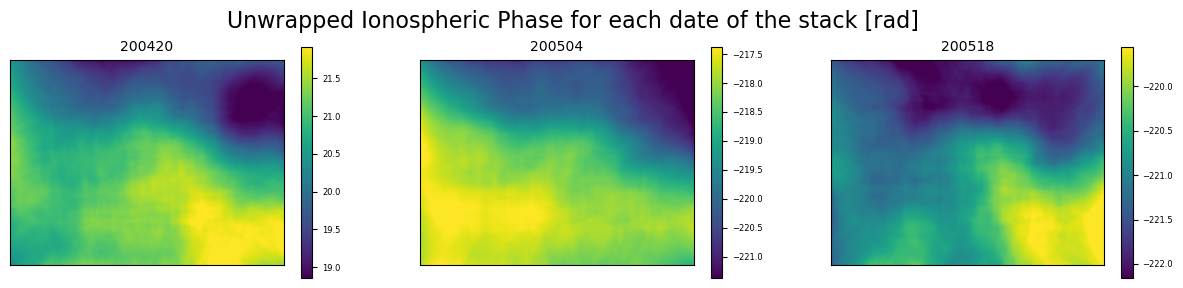

In [9]:
# plot the calculated ionospheric phase for each date
ion_files = sorted(glob.glob(os.path.join(WorkDir, 'dates_ion/*_8rlks_16alks.ion')))

nrows = int((ndates-1)/3) + (ndates-1)%3

fig, axs = plt.subplots(nrows=nrows, ncols=3, figsize=(15, 5))

fig.suptitle('Unwrapped Ionospheric Phase for each date of the stack [rad]', fontsize=16, y=0.8)

for i in range(len(ion_files)-1):
    
    ion = raster2array(ion_files[i+1])
    
    vmin = np.percentile(ion, 2)
    vmax = np.percentile(ion, 98)
    
    im = axs[i].imshow(ion, vmin=vmin, vmax=vmax)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(dates[i+1], size=10) # date in YYMMDD format
    
    cbar = plt.colorbar(im, ax=axs[i], shrink=0.6)
    cbar.ax.tick_params(labelsize=6)
    
plt.subplots_adjust(wspace=0.2, hspace=0)

plt.show()

<div style="background-color: lightblue; padding: 10px; border-left: 6px lightblue;">
  The figure displays the ionospheric phase for each acquisition date, with the reference date not displayed as it has been asummed as zero. This visualization shows the temporal variation in the ionospheric delay, with each date's ionospheric phase value represented along a color scale. By setting the reference date to zero, any phase shifts due to the ionosphere are clearly highlighted relative to this baseline.
</div>  

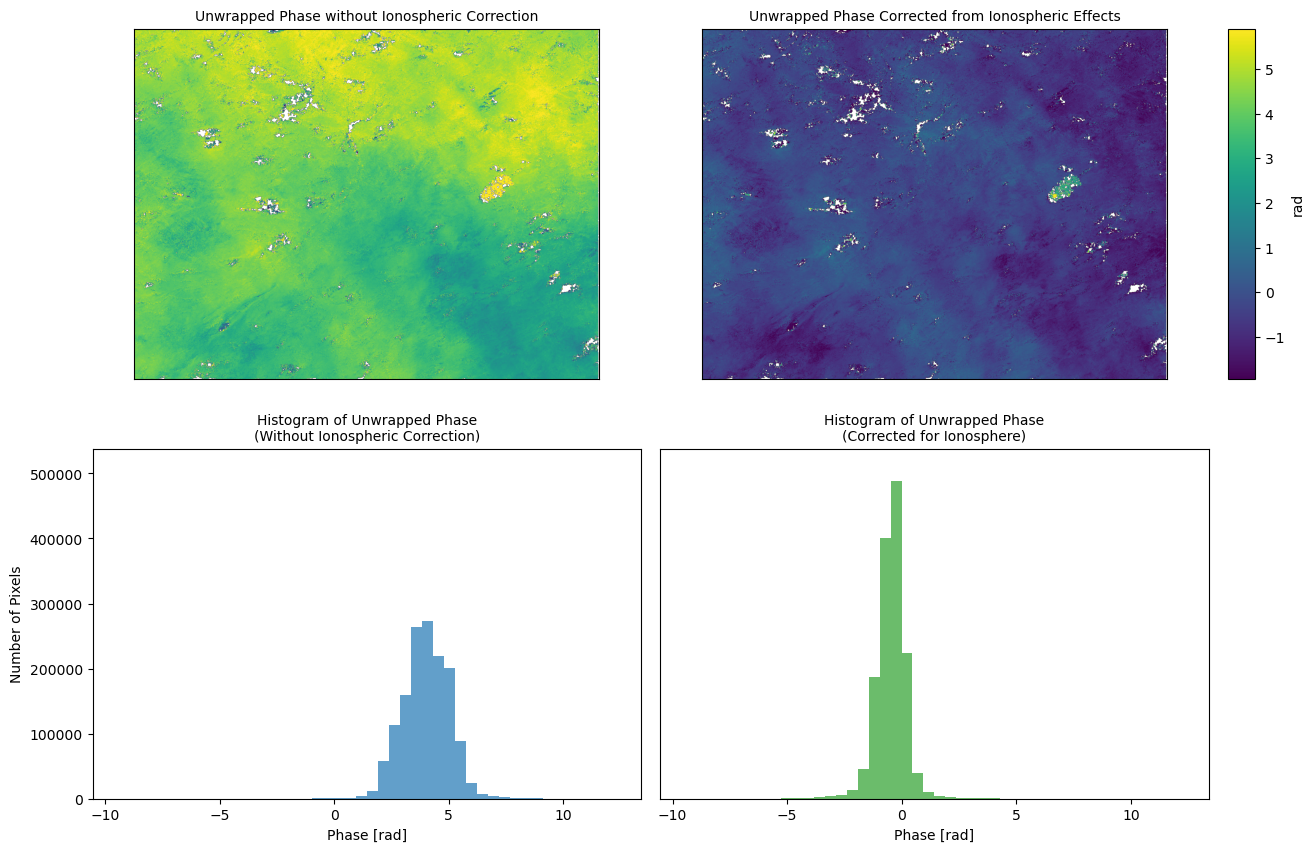

In [11]:
# plot insar pairs with ionospheric correction
# select pair
insarpair = '200406-200420' # CHANGE

# make the plot
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.05], wspace=0.05)

# Axes for images
ax00 = plt.subplot(gs[0,0])
ax01 = plt.subplot(gs[0,1])
ax10 = plt.subplot(gs[1,0])
ax11 = plt.subplot(gs[1,1])
# Axes for colorbar
cax = plt.subplot(gs[0,2])

phase_mask_file = os.path.join(WorkDir, 'pairs', insarpair, 'insar', f'filt_{insarpair}_8rlks_16alks_msk_ori.unw')
phase_mask = raster2array(phase_mask_file, [1])[:,:,0]
phase_mask[phase_mask==0.] = np.nan

phase_corr_mask_file = os.path.join(WorkDir, 'pairs', insarpair, 'insar', f'filt_{insarpair}_8rlks_16alks_msk.unw')
phase_corr_mask = raster2array(phase_corr_mask_file, [1])[:,:,0]
phase_corr_mask[phase_corr_mask==0.] = np.nan

# Common color scale
vmin = min(np.nanpercentile(phase_corr_mask, 2), np.nanpercentile(phase_mask, 2))
vmax = max(np.nanpercentile(phase_corr_mask, 98), np.nanpercentile(phase_mask, 98))

im0 = ax00.imshow(phase_mask, vmin=vmin, vmax=vmax, cmap='viridis')
ax00.set_title('Unwrapped Phase without Ionospheric Correction', fontsize=10)
ax00.set_xticks([])
ax00.set_yticks([])

im1 = ax01.imshow(phase_corr_mask, vmin=vmin, vmax=vmax, cmap='viridis')
ax01.set_title('Unwrapped Phase Corrected from Ionospheric Effects', fontsize=10)
ax01.set_xticks([])
ax01.set_yticks([])

cb = plt.colorbar(im1, cax=cax)
cb.set_label('rad')

# Histogram settings
bins = 50
range_min = min(np.nanmin(phase_mask), np.nanmin(phase_corr_mask))
range_max = max(np.nanmax(phase_mask), np.nanmax(phase_corr_mask))
hist_range = (range_min, range_max)

# Compute histograms first to determine common y-limit
hist0, _ = np.histogram(phase_mask.flatten(), bins=bins, range=hist_range)
hist1, _ = np.histogram(phase_corr_mask.flatten(), bins=bins, range=hist_range)
ymax = max(np.max(hist0), np.max(hist1)) * 1.1  # add some space

# Histogram: uncorrected
ax10.hist(phase_mask.flatten(), bins=bins, range=hist_range, color='tab:blue', alpha=0.7)
ax10.set_title('Histogram of Unwrapped Phase\n(Without Ionospheric Correction)', fontsize=10)
ax10.set_xlabel('Phase [rad]')
ax10.set_ylabel('Number of Pixels')
ax10.set_xlim(hist_range)
ax10.set_ylim(0, ymax)

# Histogram: corrected
ax11.hist(phase_corr_mask.flatten(), bins=bins, range=hist_range, color='tab:green', alpha=0.7)
ax11.set_title('Histogram of Unwrapped Phase\n(Corrected for Ionosphere)', fontsize=10)
ax11.set_xlabel('Phase [rad]')
ax11.set_xlim(hist_range)
ax11.set_ylim(0, ymax)
ax11.set_yticks([])


plt.show()

<div style="background-color: lightblue; padding: 10px; border-left: 6px lightblue;">
  This figure highlights the effect of ionospheric corrections on interferometric radar data, both visually and quantitatively through the histograms. The corrected phase image shows reduced ionospheric effects, providing more accurate surface deformation measurements. The histograms highlight the shift in phase distribution after applying the correction and reduced noise. 
</div>  

---

<div style="display: flex; align-items: center; justify-content: space-between;">
    <div>
    <img src="https://eo-persist.eu/wp-content/uploads/2024/03/EN-Funded-by-the-EU-POS-300x63.jpg" alt="Description" width="300">
  </div>
  <div style="flex: 1; padding-right: 20px; color: darkgray; font-style: italic; font-weight: bold;">
    <p>This project has received funding from the European Union’s Horizon 2020 research and innovation programme under grant agreement No. 101086386.</p>
  </div>
</div>